In [37]:
from pipeline import experiment
import datajoint as dj
import matplotlib.pyplot as plt
import numpy as np
import static_nda as nda
import pandas as pd

In [16]:
experiment.PhotodiodeCalibration.heading

# Photodiode luminance calibration
rig                  : char(8)                      # multiphoton imaging setup
trial                : int                          # repetitions
pixel_value          : mediumint                    # control pixel value
---
luminance            : double                       # luminance in cd/m^2
pd_voltage           : double                       # photodiode voltage at specified luminance in V
blanking=0           : tinyint                      # 1=blanking, 0=no blanking during calibration
ts=CURRENT_TIMESTAMP : timestamp                    # timestamp
notes=null           : varchar(255)                 # 
monitor_type=null    : varchar(16)                  # 
illumination=null    : varchar(16)                  # 
power_per_area=null  : double                       # 

In [31]:
calib_rest = {'rig':'2P4'}
# dj.U('blanking').aggr(experiment.PhotodiodeCalibration & calib_rest,n='count(*)')
ts,lums,blanks = (experiment.PhotodiodeCalibration & calib_rest).fetch('ts','luminance','blanking')
scan_dates = (experiment.Session & nda.Scan()).fetch('session_date')

In [ ]:
post_loss_sessions = experiment.Session.proj(datediff='DATEDIFF(session_date,"2020-02-08")') & 'datediff>0'


In [41]:
dj.U('notes','monitor_type','illumination','power_per_area') & (experiment.PhotodiodeCalibration & calib_rest & 'trial>=9')

notes,monitor_type,illumination,power_per_area
"Minimal Blanking, blanking duration in both channels = 4 usec",LCD,RGB,nan
"Minimum blanking, both channels blanking duration = 4 usec, max luminance approx 3 cd/sq-m",LCD,RGB,nan
"Power: 41.09V, 0.007A, M3, CV Mode, Korad power supply",LCD,RGB,nan


In [68]:
fetch_str = ['trial','ts','pixel_value','luminance','pd_voltage','notes','blanking']
trials,ts,pxs,lums,pds,notes,blanks = (experiment.PhotodiodeCalibration & calib_rest &
                                         'trial>=9').fetch(*fetch_str)

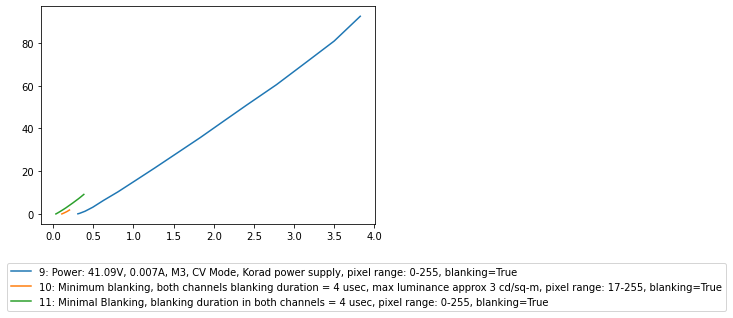

In [77]:
for trial,note in zip(set(trials),set(notes)):
    trial_idx = trials==trial
    label = str(trial) + ': ' + note + ', pixel range: ' + \
            str(np.min(pxs[trial_idx])) + '-' + str(np.max(pxs[trial_idx])) + \
                ', blanking=' + str(bool(list(set(blanks[trial_idx]))[0]))
    plt.plot(pds[trial_idx],lums[trial_idx],label=label)
    plt.legend(loc=[-0.1,-0.4])
    

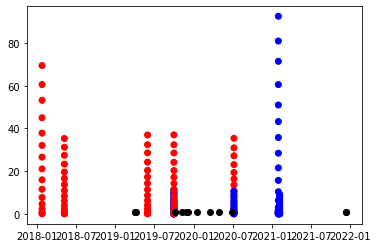

In [33]:
plt.scatter(ts,lums,color=[{0:'r',1:'b'}[b] for b in blanks])
plt.scatter(scan_dates,np.ones(len(scan_dates)),color='k')

In [ ]:
0-10 candelas/sq-m

In [85]:
plat = dj.create_virtual_module('pipeline_platinum','pipeline_platinum')

In [89]:
from stimulus import stimulus

In [94]:
moncalib_key = {'animal_id':17358, 'session':10, 'scan_idx':4}
dj.U('stimulus_type').aggr((stimulus.Trial & moncalib_key) * stimulus.Condition,n='count(*)')

stimulus_type class name of the special stimulus condition table class,n calculated attribute
stimulus.Blank,52


In [109]:
pd.DataFrame(nda.Scan())

,animal_id,session,scan_idx,nframes,nfields,fps
0,21067,9,17,48252,10,7.97908
1,21067,10,18,49431,10,7.97908
2,21067,13,14,52671,10,7.97908
3,22620,4,15,49122,10,7.97908
4,22620,4,17,51593,10,7.97908
5,22620,5,11,48647,10,7.97908
6,22846,2,19,48050,10,7.97908
7,22846,2,21,55188,10,7.97908
8,22846,7,15,48123,10,7.97908
9,22846,10,16,48475,10,7.97908


In [ ]:
import os
from pipeline.utils.h5 import read_behavior_file

In [141]:
full_scan_file

'/mnt/scratch06/Two-Photon/taliah/2019-04-02_09-14-06/21067_9_00005_00001.tif'

In [194]:
calib_df = []
for scan in nda.Scan():
    session_key = {'animal_id':scan['animal_id'], 'session':scan['session']}
    mon_calib_candidates = dj.U('animal_id','session','scan_idx').aggr((stimulus.Trial & session_key)*
                                                                       stimulus.Blank,n='count(*)')
    mon_calib_candidates = mon_calib_candidates & 'n=52'
    
    for mon_calib_candidate in mon_calib_candidates.proj():
        scan_path = (experiment.Scan & mon_calib_candidate).local_filenames_as_wildcard
        scan_dir = os.path.split(scan_path)[0]

        scan_file = (experiment.Scan & mon_calib_candidate).fetch1('filename')
        behavior_file = (experiment.Scan.BehaviorFile() & mon_calib_candidate).fetch1('filename')

        full_scan_file = os.path.join(scan_dir, f"{scan_file}_00001.tif")
        full_beh_file = os.path.join(scan_dir, behavior_file)

        scan_on = os.path.isfile(full_scan_file)
        
        data = read_behavior_file(full_beh_file)
        
        ts = data["ts"]
        pd = data["syncPd"]
        trial_starts = data["trialnum_ts"][1]
        
        # deal with 32-bit unsigned integer wrapping
        wrap_idx = np.where(np.diff(trial_starts) < 0)[0] 
        if (len(wrap_idx) > 0):
            for i in range(len(wrap_idx)):
                trial_starts[wrap_idx[i]+1:] = 2**32 + trial_starts[wrap_idx[i]+1:]

        
        calib_df.append({**mon_calib_candidate,'ts':ts,'pd':pd,
                         'trial_starts':trial_starts,'scan_on':scan_on,'data':data})
        


In [195]:
import pandas as pd

In [196]:
calib_df = pd.DataFrame(calib_df)

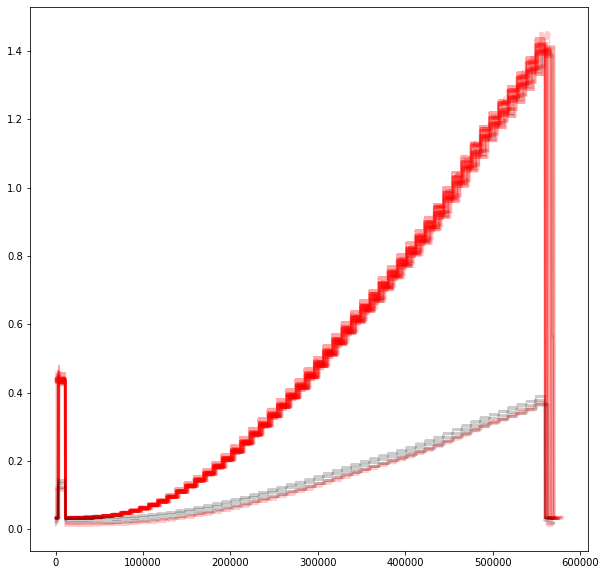

In [244]:
fig,ax = plt.subplots(figsize=(10,10))
for ts,diode,scan,starts in zip(calib_df['ts'],calib_df['pd'],calib_df['scan_on'],calib_df['trial_starts']):
    mod_ts = ts.copy()
    trial_length = np.median(np.diff(starts))
    trial_idx = np.logical_and(ts>=(starts[0]-trial_length), ts<=(starts[-1]+2*trial_length))
    mod_ts -= mod_ts[0]
    mod_ts[mod_ts<0] += 2**32
    ax.plot(diode[trial_idx],c={True:'k',False:'r'}[scan],alpha=0.2)

In [247]:
for diode in calib_df[calib_df['scan_on']==True]['pd']:
    print(np.min(diode),np.max(diode))

0.013956533426783813 1.402433437437006
0.026130390148620324 0.3916750555490814
0.02349820492233837 0.37950120264564846
0.015601649207503784 0.3669983265595592


In [248]:
for diode in calib_df[calib_df['scan_on']==False]['pd']:
    print(np.min(diode),np.max(diode))

0.01790481129657433 1.3902595947326672
0.017575788141274053 1.3899305719552133
0.013956533426783813 1.412633143394483
0.013627510270358557 1.3974980958145342
0.019220903916838086 1.4149363027926187
0.01790481129657433 1.4251360086472211
0.01790481129657433 1.4234908948053788
0.01790481129657433 1.4205296898845636
0.01790481129657433 1.4251360086472211
0.01790481129657433 1.4234908948053788
0.01790481129657433 1.4205296898845636
0.015930672363366524 1.433690600589632
0.01625969551913552 1.4198716443456445
0.015930672363366524 1.4185555532667584
0.016917741830392272 1.4001302780156328
0.01658871867481077 1.3955239591600392
0.032710853188090756 1.4379678965387208
0.016917741830392272 1.4001302780156328
0.01658871867481077 1.3955239591600392
0.032710853188090756 1.4379678965387208
0.019220903916838086 1.4057236651743974
0.018891880761912748 1.4017753918884792
0.016917741830392272 1.3981561413653332
0.016917741830392272 1.3948659136078418
0.013627510270358557 1.4123041206229714
0.0136275102

In [ ]:
# Code borrowed from Moncalib
scan_path = (Scan & moncalib_key).local_filenames_as_wildcard
scan_dir = os.path.split(scan_path)[0]

scan_file = (Scan & moncalib_key).fetch1('filename')
behavior_file = (Scan.BehaviorFile() & moncalib_key).fetch1('filename')

full_scan_file = os.path.join(scan_dir, f"{scan_file}_00001.tif")
full_beh_file = os.path.join(scan_dir, behavior_file)

scan_on = os.path.isfile(full_scan_file)

data = read_behavior_file(full_beh_file)


In [ ]:
from pipeline.utils.h5 import read_behavior_file
from scipy.optimize import curve_fit
from scipy import interpolate


In [ ]:

# deal with 32-bit unsigned integer wrapping
wrap_idx = np.where(np.diff(trial_starts) < 0)[0] 
if (len(wrap_idx) > 0):
    for i in range(len(wrap_idx)):
        trial_starts[wrap_idx[i]+1:] = 2**32 + trial_starts[wrap_idx[i]+1:]

if len(trial_starts) != 52: # 52 pixel values (0:255:5)
    self.insert1(dict(key, scan_on=scan_on, valid=False))
    return

trial_length = np.diff(trial_starts).mean()
trial_ends = np.concatenate([trial_starts[1:], [trial_starts[-1] + trial_length]])

median_pd = []
for start, end in zip(trial_starts, trial_ends):
    trial_mask = (ts > start) & (ts < end)
    median_pd += [np.median(pd[trial_mask])]

pixel_value = np.linspace(0, 255, 52)
pixel_value_for_fit = pixel_value.copy()
pixel_value_for_fit[0] = 1e-9


In [ ]:
@schema
class MonitorCalibrationFromH5(dj.Lookup):
    definition = """ # monitor luminance calibration
    -> experiment.PhotodiodeCalibration.proj(dummy_pdcalib_pixel='pixel_value', pdcalib_blanking='blanking')
    -> experiment.Scan
    ---
    pixel_value             : mediumblob      # control pixel value (0-255)
    median_pd               : mediumblob      # median photodiode value
    luminance               : mediumblob      # luminance in cd/m^2
    amplitude               : float           # lum = Amp*pixel_value^gamma + offset
    gamma                   : float           #
    offset                  : float           #
    ts                      : timestamp       # timestamp
    """

    @staticmethod
    def func(x, a, b, m):
        return a + b * (x**m)

    def get_gamma_function(self, moncalib_key, pdcalib_key):
        from pipeline.utils.h5 import read_behavior_file
        from scipy.optimize import curve_fit
        from scipy import interpolate
        
        # Code borrowed from Moncalib
        scan_path = (Scan & moncalib_key).local_filenames_as_wildcard
        scan_dir = os.path.split(scan_path)[0]

        scan_file = (Scan & moncalib_key).fetch1('filename')
        behavior_file = (Scan.BehaviorFile() & moncalib_key).fetch1('filename')

        full_scan_file = os.path.join(scan_dir, f"{scan_file}_00001.tif")
        full_beh_file = os.path.join(scan_dir, behavior_file)

        scan_on = os.path.isfile(full_scan_file)

        data = read_behavior_file(full_beh_file)

        ts = data["ts"]
        pd = data["syncPd"]
        trial_starts = data["trialnum_ts"][1]
        
        # deal with 32-bit unsigned integer wrapping
        wrap_idx = np.where(np.diff(trial_starts) < 0)[0] 
        if (len(wrap_idx) > 0):
            for i in range(len(wrap_idx)):
                trial_starts[wrap_idx[i]+1:] = 2**32 + trial_starts[wrap_idx[i]+1:]

        if len(trial_starts) != 52: # 52 pixel values (0:255:5)
            self.insert1(dict(key, scan_on=scan_on, valid=False))
            return

        trial_length = np.diff(trial_starts).mean()
        trial_ends = np.concatenate([trial_starts[1:], [trial_starts[-1] + trial_length]])

        median_pd = []
        for start, end in zip(trial_starts, trial_ends):
            trial_mask = (ts > start) & (ts < end)
            median_pd += [np.median(pd[trial_mask])]
    
        pixel_value = np.linspace(0, 255, 52)
        pixel_value_for_fit = pixel_value.copy()
        pixel_value_for_fit[0] = 1e-9

        # get the most recent pd calibration trial
        pixels, lums, pds = (experiment.PhotodiodeCalibration() & pdcalib_key).fetch('pixel_value', 'luminance', 'pd_voltage', order_by='pixel_value')
        # Enforces median_pd increases monotonically as pixel value increases
        diff_mask = (median_pd - median_pd[0]) >= 0.0
        median_pd = diff_mask * (median_pd - median_pd[0]) + median_pd[0]
        if min(median_pd) < min(pds):
            median_pd += min(pds) - min(median_pd)
            
        # fit a function between pd voltages and luminance 
        pd2lum_params, _ = curve_fit(self.func, pds, lums)
        # fit a function between pixel values and the pd voltages
        px2pd_params, _ = curve_fit(self.func, pixel_value_for_fit, median_pd)
        # fit a function between pixel values and luminance
        px2lum_params, _ = curve_fit(self.func, pixel_value_for_fit, self.func(median_pd, *pd2lum_params))
        
        pd_offset, pd_amplitude, pd_gamma = px2pd_params
        lum_offset, lum_amplitude, lum_gamma = px2lum_params
        
        luminance = self.func(median_pd, *pd2lum_params)
        px2lum_interp = interpolate.interp1d(pixel_value, luminance)
        inv_px2lum_interp = interpolate.interp1d(luminance, pixel_value)

        return pixel_value, median_pd, luminance, pd_offset, pd_amplitude, pd_gamma, lum_offset, lum_amplitude, lum_gamma, px2lum_interp, inv_px2lum_interp

    def fill(self, moncalib_key, pdcalib_key):
        pd_key = (experiment.PhotodiodeCalibration.proj(dummy_pdcalib_pixel='pixel_value', pdcalib_blanking='blanking') & pdcalib_key & 'dummy_pdcalib_pixel LIKE 0').fetch1('KEY')
        pixel_value, median_pd, luminance, pd_offset, pd_amplitude, pd_gamma, _, _, _, _, _ = self.get_gamma_function(moncalib_key, pdcalib_key)
        self.insert1({**pd_key, **moncalib_key, 'pixel_value': pixel_value, 'median_pd': median_pd, 'luminance': luminance,
                     'offset': pd_offset, 'amplitude': pd_amplitude, 'gamma': pd_gamma})
    
    def get_interpolation(self, moncalib_key, pdcalib_key):
        _, _, _, _, _, _, _, _, _, f, f_inv = self.get_gamma_function(moncalib_key, pdcalib_key)
        return f, f_inv

px -> photodiode calibration is performed here:
https://github.com/cajal/pipeline/blob/master/python/pipeline/experiment.py#L669
This is performed every day with the Moncalib protocol

ewang  3:24 PM
photodiode -> cd is stored here:
https://github.com/cajal/pipeline/blob/master/matlab/schemas/%2Bexperiment/PhotodiodeCalibration.m
This is performed very infrequently, and I’m not familiar with how that manual table gets filled.  But at high enough voltage (the standard monitor voltage), this relationship is very very close to linear

This table is filled when we do the luminance measurements via a Labview program. This is a totally manual process, one person measures and calls out the luminance values and another person fills the table using a measured voltage value from the photodiode channel (same channel from which we normally record the photodiode sync signal) and subsequently changes the pixel value (values range from 0 to 255).


I also have a table in pipeline_experiment that is essentially the same as Eric’s for computing median_pd, but I computed the fit between both pixel and pd as well as pixel and luminance. I also did some arbitrary correction on median_pd to avoid getting negative luminance values. I discussed with Jiakun and we agreed the correction here is not the best approach and she’s writing a new table to replace this one (although the results will be very similar anyways).